In [1]:
import numpy as np
import pandas as pd
import math
import json
import sys
import time

### data manipulation

In [2]:
def readFiles(filename):
    df = pd.read_csv(filename, header=None)
    
    # restrictions are in first row
    restr = pd.to_numeric(df.iloc[0])
    
    # drop metadata columns
    df = df.drop([0], axis=0)
    
    return df, restr

In [3]:
def restrictdf(df, restr):
    # remove restricted cols and convert to numeric
    for i, v in enumerate(df.columns):
        if restr[i] < 1:
            df = df.drop(columns=[v])
        else:
            df[v] = pd.to_numeric(df[v], errors='coerce')
            
    # drop unknown values
    df = df.dropna()
    df = df[(df != '?').all(axis=1)]
    return df

In [4]:
# normalizes all columns
def normalizedf(indf):
    df=indf.copy()
    for c in df.columns:
        colMax = df[c].max()
        colMin = df[c].min()
        
        # probably no need to normalize if the values are very small. Might have to adjust the value
#         if colMax < 1:
#             continue
        df[c] = df[c].apply(lambda x: (x - colMin)/(colMax-colMin))
    return df

### helper functions

In [5]:
def euclideanDist(point, pointArray):
    return np.sqrt(np.sum((pointArray - point) ** 2, axis=1))

In [6]:
# pass a ***vectorized*** distance function: dist(point, pointArray)
def calcDistMatrix(df, distFunctionVect):
    # must be fully numeric and normalized df
    dfarray = np.array(df)
    
    distMatrix = []
    for i, d in enumerate(dfarray):
        # performs Euclidean distance on all elements in data (vectorized)
        dists = distFunctionVect(dfarray[i], dfarray)
        distMatrix.append(dists)
    
    return pd.DataFrame(distMatrix)

In [7]:
def calcNeighborhoods(distMatrix, epsilon):    
    # iterating through a dictionary is much faster
    dfdict = distMatrix.to_dict('records')
    
    # Sorry, had to do this in one line, filters each row by epsilon
    # k+1 as index in these datasets starts at 1
    return [[k+1 for (k,v) in row.items() if v <= epsilon] for row in dfdict]

In [8]:
def calcCorePoints(neighborhoods, minpts):
    # > because the point itself should be excluded
    return [i+1 for i, v in enumerate(neighborhoods) if len(v) > minpts]

In [9]:
def densityConnected(df, pntId, neighborhoods, cores, currCluster):
    # visit each unvisited neigh, and their neighbors if core. DFS 
    # update visited, clusterid, and type
    
    if df.at[pntId, "visited"]:
        return
    df.at[pntId, "visited"] = True
    for neigh in neighborhoods[pntId-1]:
        if not df.at[neigh, "visited"]:
            df.at[neigh, "cluster"] = currCluster
            if neigh in cores:
                # continue density connectivity
                df.at[neigh, "type"] = "core"
                densityConnected(df, neigh, neighborhoods, cores, currCluster)
            else:
                df.at[neigh, "visited"] = True
                df.at[neigh, "type"] = "boundary"

### analytical functions

In [10]:
# gets centroid of numeric dataframe (not normalized)
def calcCentroid(numdf):
    return np.divide(np.sum(np.array(numdf), axis=0),len(numdf))

In [78]:
def calcSSE(dfarray, c, distFunc):
    return np.sum(np.square(distFunc(c, dfarray)))

In [77]:
# takes df ran through dbscan with visited, cluster, and type columns
def analyzeClusters(df, numdf, distFunc):
    clusters=[]
    for i, c in enumerate(df['cluster'].unique()):
        info = {}
        info["clusterID"] = i
        if c is None:
            pnts = df.loc[df['cluster'].isna()]
            info["type"] = "Noise"
        else:
            pnts = df[df['cluster'] == c]
            info["type"] = "Cluster"
        
        numpnts = numdf.loc[pnts.index]
        
        info["centroid"] = calcCentroid(numpnts)
        info["SSE"] = calcSSE(np.array(numpnts), info["centroid"], distFunc)
        
        dists = distFunc(info["centroid"], np.array(numpnts))
        df.loc[pnts.index, "distToCentroid"] = dists
        pnts = df.loc[pnts.index]
        info["maxDistToCentroid"] = max(dists)
        info["minDistToCentroid"] = min(dists)
        info["avgDistToCentroid"] = np.sum(dists)/len(pnts)
        info["numPoints"] = len(pnts)
        info["dataPoints"] = pnts
        clusters.append(info)
    return clusters

In [12]:
def printClusterInfo(clusters):
    for clusterInfo in clusters:
        for key in clusterInfo:
            if key == "dataPoints":
                print(f"{key}: \n{clusterInfo[key].to_markdown()}")
            else:
                print(f"{key}: {clusterInfo[key]}")
        print('\n')

### dbscan functions

In [13]:
def dbscan_lite(df, neighborhoods, cores):
    df["visited"] = False
    df["cluster"] = None
    df["type"] = "Noise"
    
    currCluster=0
    for c in cores:
        if not df.at[c, "visited"]:
            df.at[c, "type"] = "core"
            df.at[c, "cluster"] = currCluster 
            densityConnected(df, c, neighborhoods, cores, currCluster)
            currCluster += 1
    
    return df

In [14]:
def dbscan(indf, restr, distFunc, epsilon, minpnts, silent=False):
    df=indf.copy()
    numdf = restrictdf(df,restr)
    distMatrix = calcDistMatrix(normalizedf(numdf), distFunc)
    neighborhoods = calcNeighborhoods(distMatrix, epsilon)
    cores = calcCorePoints(neighborhoods, minpnts)
    
    df = dbscan_lite(df, neighborhoods, cores)
    
    clusters = analyzeClusters(df, numdf, distFunc)
    if not silent:
        print(f"Epsilon: {epsilon}, Min Points: {minpnts}")
        printClusterInfo(clusters)
    return clusters, df

### running

In [18]:
def hyperparams(indf, inrestr, epsmin, epsmax, mptsmin, mptsmax):
    numeps = 10
    nummpts = 10
#     epsmin=0.001
#     epsmax=0.1
#     mptsmin=2
#     mptsmax=25
    
    results=[]
    
    for e in range(numeps):
        for p in range(nummpts):
            eps = epsmin + (epsmax-epsmin)/numeps*e
            mpts = int(mptsmin + (mptsmax-mptsmin)/nummpts*p)
            
            df = indf.copy()
            restr = inrestr.copy()
            
            cl, tmp=dbscan(df, restr, euclideanDist, eps, mpts, silent=True)
            noiseLen = None
            for c in cl:
                if c["type"] == "Noise":
                    noiseLen=len(c["dataPoints"])
            results.append([eps,mpts,len(cl) - 1,noiseLen])
    return pd.DataFrame(results, columns=["epsilon","minPoints", "numClusters", "numNoisePts"])

In [16]:
# eps=0.2
# mpts=40

# sys.argv = f"dbscan.py ./data/4clusters.csv {eps} {mpts}".split(" ")
# if __name__ == "__main__":
#     if len(sys.argv) == 4:
#         _, datafile, epsilon, minpts = sys.argv
#     else:
#         print("Usage: python3 dbscan.py <datafile.csv> <epsilon> <numPoints>")
#         exit(1)
        
#     minpts = float(minpts)
#     epsilon = float(epsilon)
    
#     df, restr = readFiles(datafile)
    
#     hyp = hyperparams(df, restr, 0.1, 0.25, 2, 12)  

# 4 clusters

In [26]:
df, restr = readFiles('./data/4clusters.csv')
hyp = hyperparams(df, restr, 0.1, 0.25, 2, 12) 

print(hyp[hyp['numClusters'] == 4].to_markdown())

|    |   epsilon |   minPoints |   numClusters |   numNoisePts |
|---:|----------:|------------:|--------------:|--------------:|
|  0 |     0.1   |           2 |             4 |             8 |
|  1 |     0.1   |           3 |             4 |            13 |
| 10 |     0.115 |           2 |             4 |             8 |
| 11 |     0.115 |           3 |             4 |            11 |
| 20 |     0.13  |           2 |             4 |             6 |
| 21 |     0.13  |           3 |             4 |             6 |
| 22 |     0.13  |           4 |             4 |             8 |
| 32 |     0.145 |           4 |             4 |             4 |
| 54 |     0.175 |           6 |             4 |             6 |
| 64 |     0.19  |           6 |             4 |             5 |


Epsilon: 0.145, Min Points: 4
clusterID: 0
type: Cluster
centroid: [4.99148936 3.40425532 1.46808511 0.24042553]
SSE: 11.351063829787236
maxDistToCentroid: 1.0402427720960834
minDistToCentroid: 0.05237673883017504
avgDistToCentroid: 0.4427156872626195
numPoints: 47
dataPoints: 
|    |   0 |   1 |   2 |   3 | 4           | visited   |   cluster | type     |   distToCentroid |
|---:|----:|----:|----:|----:|:------------|:----------|----------:|:---------|-----------------:|
|  1 | 5.1 | 3.5 | 1.4 | 0.2 | Iris-setosa | True      |         0 | core     |        0.164959  |
|  2 | 4.9 | 3   | 1.4 | 0.2 | Iris-setosa | True      |         0 | core     |        0.421974  |
|  3 | 4.7 | 3.2 | 1.3 | 0.2 | Iris-setosa | True      |         0 | core     |        0.395693  |
|  4 | 4.6 | 3.1 | 1.5 | 0.2 | Iris-setosa | True      |         0 | core     |        0.498486  |
|  5 | 5   | 3.6 | 1.4 | 0.2 | Iris-setosa | True      |         0 | core     |        0.211325  |
|  6 | 5.4 | 3.9 | 1.7 | 0.4

<AxesSubplot:xlabel='0', ylabel='1'>

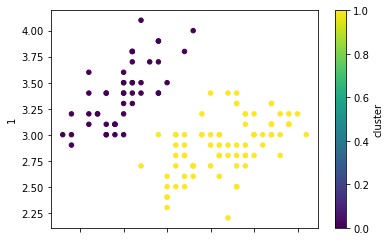

In [79]:
cl, tdf = dbscan(df, restr, euclideanDist, 0.145, 4, silent=False)
tdf.plot.scatter(x=0,y=1,c='cluster',colormap='viridis')

# Iris

In [38]:
df, restr = readFiles('./data/iris.csv')
hyp = hyperparams(df, restr, 0.1, 0.25, 2, 12) 
print(hyp[hyp['numClusters'] == 3].to_markdown())

|    |   epsilon |   minPoints |   numClusters |   numNoisePts |
|---:|----------:|------------:|--------------:|--------------:|
|  3 |     0.1   |           5 |             3 |            88 |
| 11 |     0.115 |           3 |             3 |            32 |
| 15 |     0.115 |           7 |             3 |            80 |
| 16 |     0.115 |           8 |             3 |            89 |
| 25 |     0.13  |           7 |             3 |            51 |
| 27 |     0.13  |           9 |             3 |            73 |
| 37 |     0.145 |           9 |             3 |            34 |
| 40 |     0.16  |           2 |             3 |             7 |
| 41 |     0.16  |           3 |             3 |             7 |


In [76]:
cl, tdf = dbscan(df, restr, euclideanDist, 0.145, 4)
tdf = tdf.assign(cluster = lambda x: np.where(x.cluster.isna(),-1,x.cluster))

Epsilon: 0.145, Min Points: 4
clusterID: 0
type: Cluster
centroid: [4.99148936 3.40425532 1.46808511 0.24042553]
maxDistToCentroid: 1.0402427720960834
minDistToCentroid: 0.05237673883017504
avgDistToCentroid: 0.4427156872626195
numPoints: 47
dataPoints: 
|    |   0 |   1 |   2 |   3 | 4           | visited   |   cluster | type     |   distToCentroid |
|---:|----:|----:|----:|----:|:------------|:----------|----------:|:---------|-----------------:|
|  1 | 5.1 | 3.5 | 1.4 | 0.2 | Iris-setosa | True      |         0 | core     |        0.164959  |
|  2 | 4.9 | 3   | 1.4 | 0.2 | Iris-setosa | True      |         0 | core     |        0.421974  |
|  3 | 4.7 | 3.2 | 1.3 | 0.2 | Iris-setosa | True      |         0 | core     |        0.395693  |
|  4 | 4.6 | 3.1 | 1.5 | 0.2 | Iris-setosa | True      |         0 | core     |        0.498486  |
|  5 | 5   | 3.6 | 1.4 | 0.2 | Iris-setosa | True      |         0 | core     |        0.211325  |
|  6 | 5.4 | 3.9 | 1.7 | 0.4 | Iris-setosa | True   

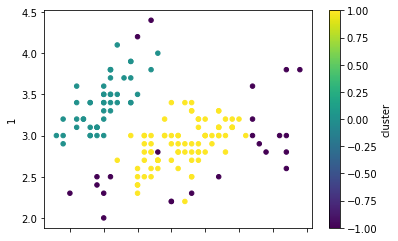

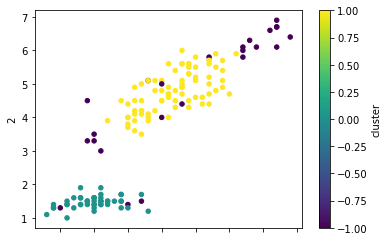

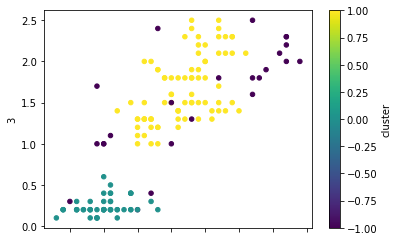

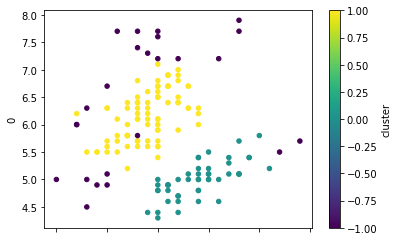

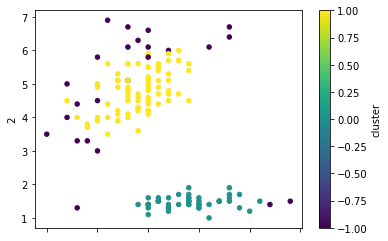

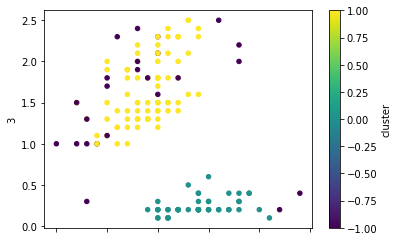

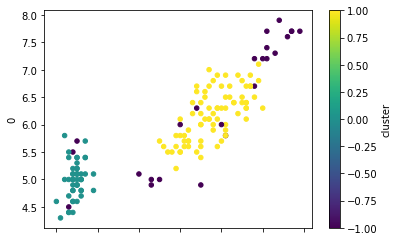

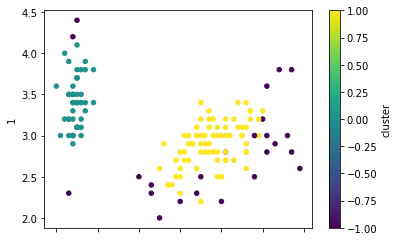

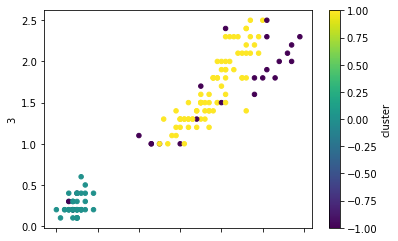

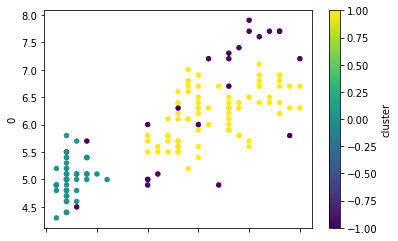

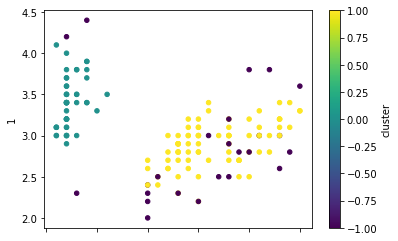

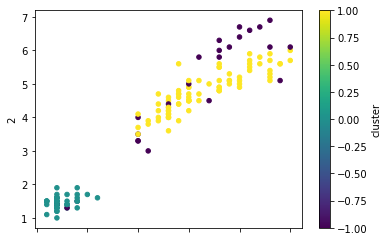

In [74]:
for i in range(4):
    for j in range(4):
        if i!=j:
            tdf.set_index(j)
            tdf.index.name=j 
            plt = tdf.plot.scatter(colormap='viridis',x=i,y=j, c='cluster')